In [1]:
from orbit import Orbit, AU2km, mu, day2s
import elements as el
import angles as an
from util import load_dataset
from lambert_izzo import lambert as lambert_izzo

from lambert import lambert as lambert_bate

import sys

import numpy as np
from numpy.linalg import norm
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import logging

# Load datasets
Created a small function to load asteroids directly into a set
earth is also created at MJD5400

In [2]:
asteroids, earth = load_dataset()
ISP = 3000*9.80665/1000 #km/s

In [3]:
type(asteroids), len(asteroids)

(set, 1436)

In [4]:
# defined a helper function get the specific asteroid im looking for

def select_asteroid(index):   
    """Helper function to get the asteroid orbit at given index"""
    #maybe just using lists is easier?
    #but this function can also be memoizeddddd
    if index == -1:
        return earth
    return [ast for ast in asteroids if ast.index==index][0]

In [5]:
select_asteroid(1057)

'2006QV89'

In [6]:
def lambert(*args):
    try:
        return lambert_izzo(*args)
    except:
        try:
            return lambert_bate(*args)
        except:
            raise RunTimeError('Failed to solve Lamberts')

# Idea
define a node as a (`Orbit`, `asteroid index`) which describes the position and state vector fully. Then the children nodes are defined by the set of all possible new orbits to transition into. Cost_so_far is defined as total deltavs needed so far. While the velocity at a node does not match with the asteroid's velocity, we define it as a flyby or a specific asteroid. 

`node.len_of_chain()` returns the number of flybys it has found. Therefore the merit function is simply number of asteroids + mf/m0 and since mf/m0 will always be less than 1, this function is the explict form of the problem statement. 

In [7]:
# implemention of Dijkstra’s from https://www.redblobgames.com/pathfinding/a-star/implementation.html

import heapq

class PriorityQueue:
    def __init__(self):
        self.elements = []
    
    def empty(self):
        return len(self.elements) == 0
    
    def put(self, item, priority):
        heapq.heappush(self.elements, (priority, item))
    
    def get(self):
        return heapq.heappop(self.elements)[1]

In [8]:
class Node():
    
    def __init__(self, epoch, index, approach_orbit=None, parent=None):
        
        
        self.epoch = epoch
        self.index = index
        self.asteroid = select_asteroid(index)
            
        self.approach_orbit = approach_orbit 
        #this is the orbit that defined at parents epoch and position,
        # and gets me to this asteroid's position at required epoch
        
        self.parent_node = parent
        
        if self.parent_node is None:
            self.visited_list = [self.index]
        else:
            self.visited_list = self.parent_node.visited_list + [self.index]

        
    def children(self):
        
        permitted_asteroids = asteroid_ind.difference(set(self.visited_list))
        
        
        return len(permitted_asteroids)
    
    def len_of_chain(self):
        
        if self.parent_node is None:
            return 0
        
        return 1 + self.parent_node.len_of_chain()
    
    
    def create_next_node(self, target_ind, target_epoch):

        t0 = self.epoch
        r0, v0 = self.approach_orbit.rv()

        # find next ast and get its position (vel not needed)
        ast = select_asteroid(target_ind)
        r_target, v_target = ast.rv(target_epoch)

        # solve lamberts problem
        v1, v2 = lambert(mu, r0, r_target, (target_epoch-t0)*day2s)

        # note that a maneouver is needed at the initial epoch to set us on a rendevousz path with target ast
        dv=v1-v0 # only the initial change in velocity needed
        
        
        #incrememental cost
        if self.parent_node is None:
            # starting at earth
            inc_cost = max(0, norm(dv)-4.0) 
        else:
            inc_cost = norm(dv)

        # create new orbit, index=-2 since it is a transfer
        o_new = Orbit(name=f'Trx{self.len_of_chain()+1:2.0f}')
        o_new.from_rv(target_epoch, r_target, v2)    

        # create new node
        new_Node = Node(epoch = target_epoch, index = target_ind, approach_orbit=o_new, parent=self)

        # update cost and manouever history
        new_Node.maneuvers = self.maneuvers + [(t0, dv)]
        new_Node.cost = self.cost + inc_cost

        return new_Node
    
    def get_priority(self, dv=True, mf=False, count=False):
        
        # overall objective function is to maximise (number of asteroids + mf/m0)

        priority = 0
        
        if count: priority += self.len_of_chain()
        if mf   : priority += np.exp(-self.cost/ISP)
        if dv   : priority += -self.cost
        
        return -priority
        
        
    # printing tools
    def __repr__(self):
        
        return f'MJD {self.epoch:6.2f}, {self.asteroid.index:6.0f},    {self.asteroid},'
    
    def history(self):
        
        # call print(node.history()) to get the reverse sequence of nodes
        if self.parent_node is None:
            return 'Epoch,         Index,    Name,\n\n' + repr(self)
        
        return f'{self.parent_node.history()}\n{self}'
    
    def plot(self, only_traj=False):
        
        if self.parent_node is None:
            plt.plot(0,0,'x')
            plt.grid()
            ax=plt.gca()
            ax.set_aspect(1)
            
            
        else:
            self.parent_node.plot(only_traj)
        
        if not only_traj:
            #plot orbit of current asteroid,
            self.asteroid.plot(start=self.epoch)
        
        (rx, ry, rz), v = self.asteroid.rv(self.epoch)
        plt.text(rx/AU2km,ry/AU2km, f'{self.len_of_chain()}')
        
        #plot current approach trajectory
        if self.parent_node is not None:
            self.approach_orbit.plot(start=self.parent_node.epoch, end=self.epoch)
        

Define the starting point of the trajectory

In [9]:
launch_epoch = 58676.40
rv_earth = earth.rv(epoch = launch_epoch)
earth_initial = Orbit(name='Earth', index=-1)
earth_initial.from_rv(launch_epoch, *rv_earth)
earth_initial

Earth

In [10]:
earth_initial.epoch0

58676.4

Create the initial node

In [11]:
#epoch, index, approach_orbit=None, parent=None
start_node = Node(launch_epoch, index=-1, approach_orbit=earth_initial, parent=None)
start_node.cost = 0.0
start_node.maneuvers = []

In [12]:
# we can query the standard stuff also about the root node
start_node.len_of_chain(), start_node.get_priority()

(0, -0.0)

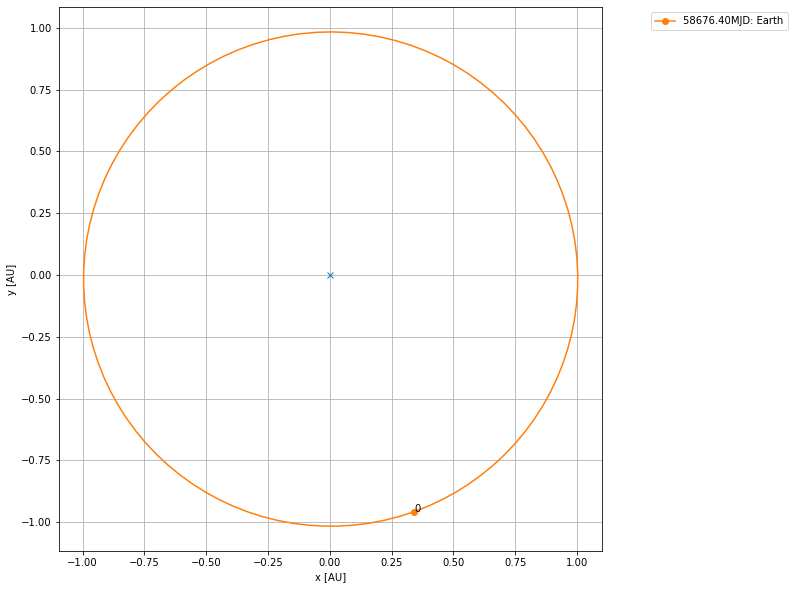

In [13]:
#PLOT!
fig = plt.figure(figsize=(10,10))
start_node.plot()
plt.legend()
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.35, 1))

# Define the first node
based on russian paper

In [14]:
first_node = start_node.create_next_node(target_ind=1057, target_epoch=58731.65)

In [15]:
# get cost and priority
first_node.cost, first_node.get_priority()

(0.0, -0.0)

In [16]:
print(first_node.history())

Epoch,         Index,    Name,

MJD 58676.40,     -1,    Earth,
MJD 58731.65,   1057,    '2006QV89',


In [17]:
first_node.len_of_chain()

1

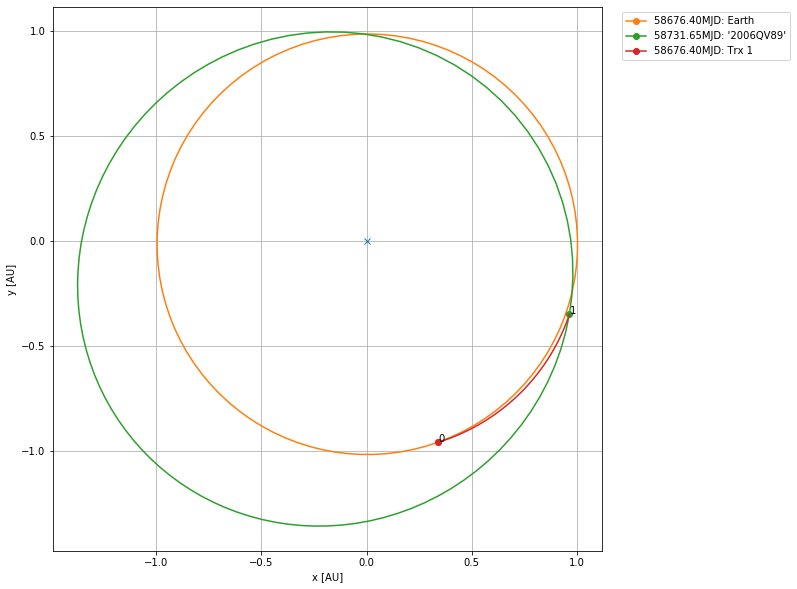

In [18]:
# PLOT
fig = plt.figure(figsize=(10,10))
first_node.plot() 
plt.legend()
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.35, 1))

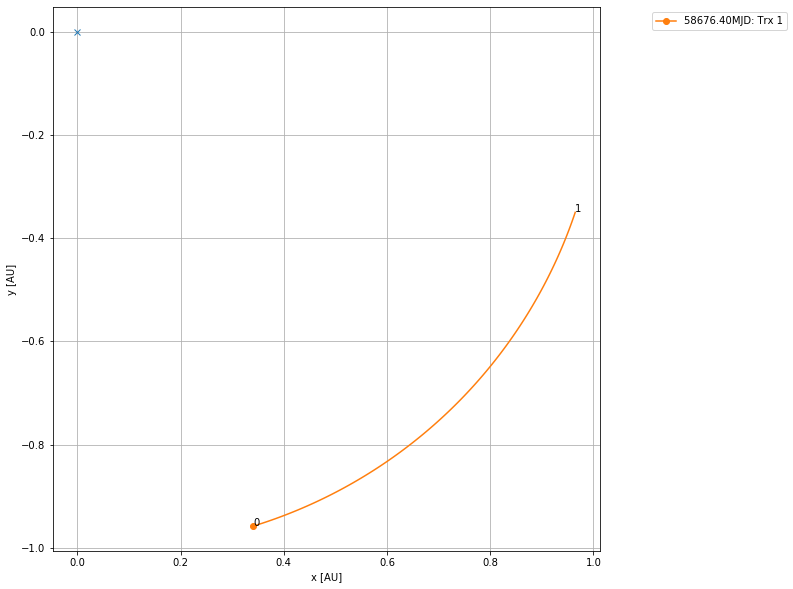

In [19]:
# PLOT
fig = plt.figure(figsize=(10,10))
first_node.plot(only_traj=True) 
plt.legend()
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.35, 1))

# second node

In [20]:
second_node = first_node.create_next_node(target_ind=1125, target_epoch=58801.45)

In [21]:
second_node.maneuvers

[(58676.4, array([-0.20509971, -1.43631196,  0.07282867])),
 (58731.65, array([-0.11494312,  0.08768156,  0.20003526]))]

In [22]:
second_node.cost, second_node.get_priority()

(0.24680777922686292, 0.24680777922686292)

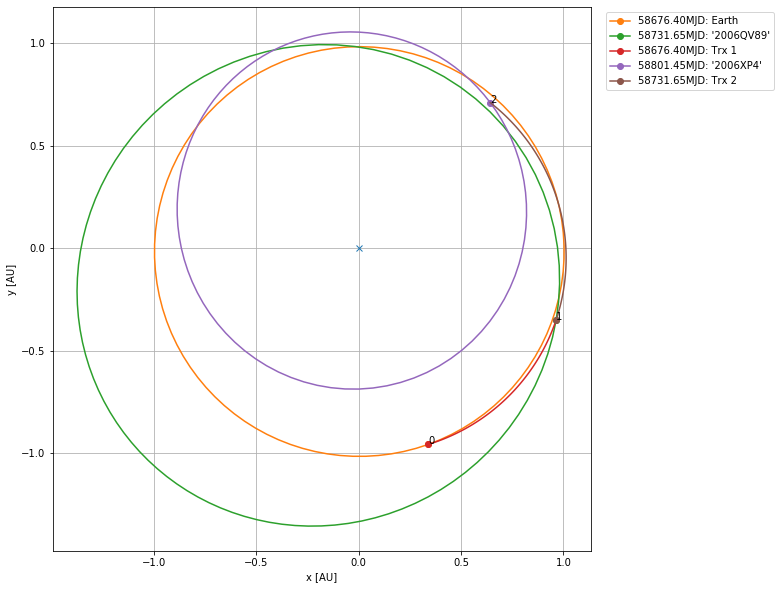

In [23]:
fig = plt.figure(figsize=(10,10))
second_node.plot() 
plt.legend()
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.35, 1))

# thrid node

In [24]:
third_node = second_node.create_next_node(target_ind=1328, target_epoch=58866.95)

In [25]:
print(third_node.history())

Epoch,         Index,    Name,

MJD 58676.40,     -1,    Earth,
MJD 58731.65,   1057,    '2006QV89',
MJD 58801.45,   1125,    '2006XP4',
MJD 58866.95,   1328,    '2008EP6',


In [26]:
third_node.maneuvers

[(58676.4, array([-0.20509971, -1.43631196,  0.07282867])),
 (58731.65, array([-0.11494312,  0.08768156,  0.20003526])),
 (58801.45, array([-0.32988735,  0.52634144,  0.14795608]))]

In [27]:
third_node.cost

0.8853623747672904

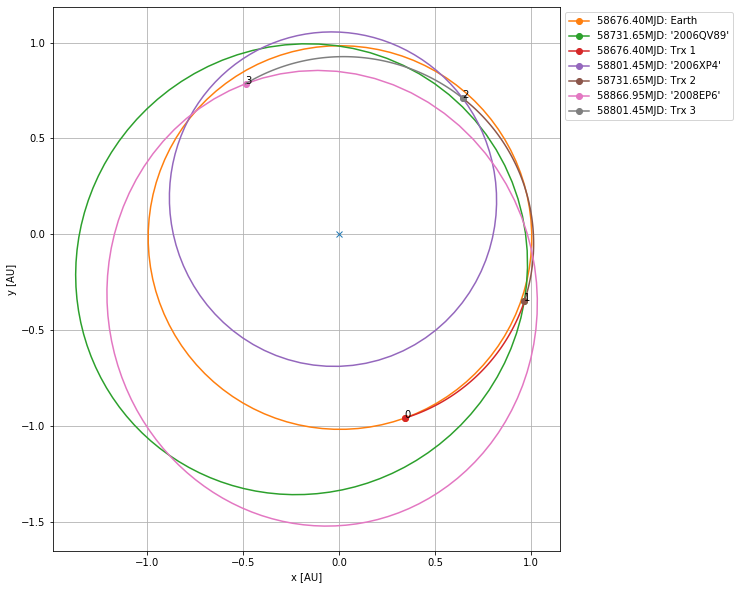

In [28]:
fig = plt.figure(figsize=(10,10))
third_node.plot() 
plt.legend()
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.35, 1))

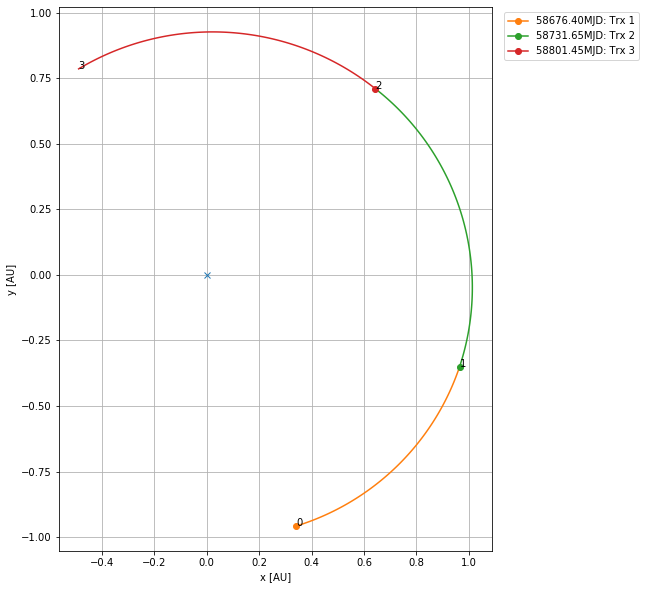

In [29]:
fig = plt.figure(figsize=(10,10))
third_node.plot(only_traj=True) 
plt.legend()
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.35, 1))

# Try to define a sequence
based on russian paper

In [30]:
t_list = [58731.65, 58801.45, 58866.95, 58973.95, 59084.55, 59119.45, 59221.75,59326.95, 59366.25,59419.55]
ind_list = [1057, 1125, 1328, 1181, 937,1077, 1289, 1000, 601, 1376]

In [31]:
nodes = [start_node]

In [32]:
for i, ind in enumerate(ind_list):
    new_node = nodes[-1].create_next_node(target_ind = ind, target_epoch=t_list[i])
    nodes.append(new_node)
    

In [33]:
nodes

[MJD 58676.40,     -1,    Earth,,
 MJD 58731.65,   1057,    '2006QV89',,
 MJD 58801.45,   1125,    '2006XP4',,
 MJD 58866.95,   1328,    '2008EP6',,
 MJD 58973.95,   1181,    '2007KV2',,
 MJD 59084.55,    937,    '2005XN27',,
 MJD 59119.45,   1077,    '2006TB7',,
 MJD 59221.75,   1289,    '2008AF4',,
 MJD 59326.95,   1000,    '2006HF6',,
 MJD 59366.25,    601,    '2003LW2',,
 MJD 59419.55,   1376,    '2008PK3',]

In [34]:
final_node = nodes[-1]

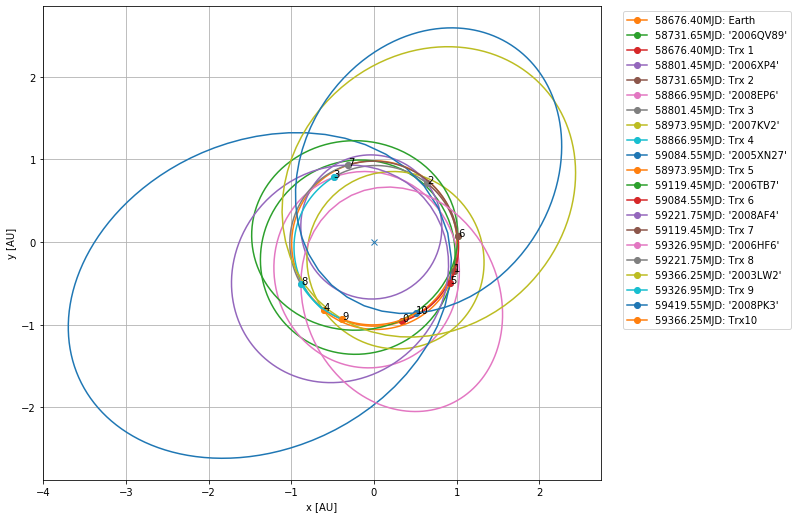

In [35]:
fig = plt.figure(figsize=(10,10))
final_node.plot()
plt.legend()
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.35, 1))


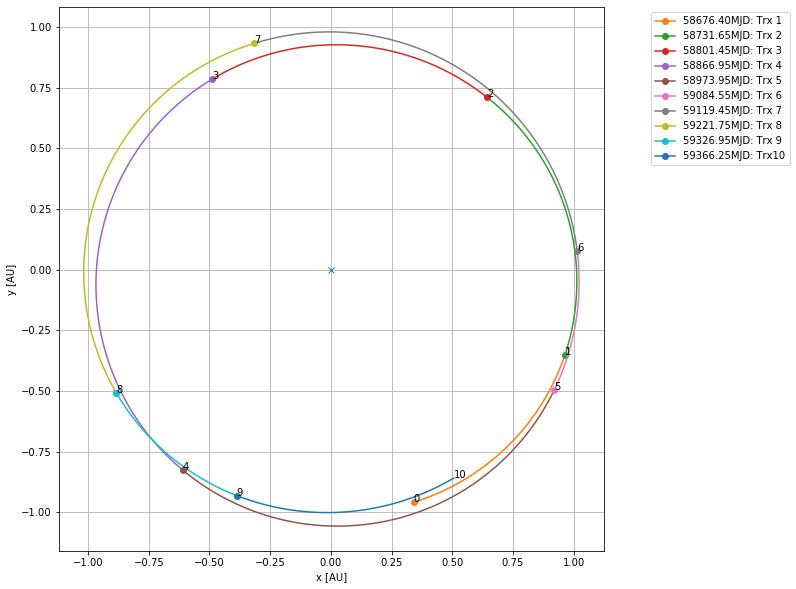

In [36]:
fig = plt.figure(figsize=(10,10))
final_node.plot(only_traj=True)
plt.legend()
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.35, 1))

In [37]:
final_node.maneuvers

[(58676.4, array([-0.20509971, -1.43631196,  0.07282867])),
 (58731.65, array([-0.11494312,  0.08768156,  0.20003526])),
 (58801.45, array([-0.32988735,  0.52634144,  0.14795608])),
 (58866.95, array([0.15972231, 0.02929418, 0.02763234])),
 (58973.95, array([ 0.04873194, -0.08043569,  0.26002869])),
 (59084.55, array([ 0.20222521,  0.30944667, -0.10444501])),
 (59119.45, array([-0.02882234,  0.15765074, -0.05001421])),
 (59221.75, array([0.5126921 , 0.58991377, 0.14833961])),
 (59326.95, array([ 0.12108697, -0.09079498, -0.04067516])),
 (59366.25, array([ 0.4458898 , -0.16419913,  0.43552919]))]

In [38]:
final_node.cost

3.475424916379235

In [39]:
final_node.get_priority(dv=False, mf=True, count=False)

-0.8885791335530434

In [40]:
ISP

29.419949999999996

In [41]:
np.exp(-final_node.cost/ISP)

0.8885791335530434

In [42]:
final_node.maneuvers[0][1]

array([-0.20509971, -1.43631196,  0.07282867])